In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  regexp_extract, col ,count, sum, avg
from pyspark.sql.window import Window
from pyspark.sql.functions import rank ,datediff , when , concat_ws, to_date , dayofweek , year
import matplotlib.pyplot as plt
import seaborn as sns

#initialise spark session
spark = SparkSession.builder.appName("ParkingTicketsAnalysis").config("spark.sql.debug.maxToStringFields", 1000).getOrCreate()

#Loading the data:
path = r"NYC_Parking_Tickets.csv"
cleaned_df = spark.read.csv(path, inferSchema = True , header = True)

# Print the schema and RowCount in Data Frame
cleaned_df.printSchema()
cleaned_df.show()
cleaned_df.count()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Coun

9100278

In [14]:
#Removiong below columns from pyspark 

columns_to_remove = ["No Standing or Stopping Violation","Hydrant Violation","Double Parking Violation","Latitude",
                     "Longitude","Community Board","Community Council","Census Tract","BIN","BBL","NTA"]
Removed_ColumnsContainingNulls_df = cleaned_df.drop(*columns_to_remove)
Removed_ColumnsContainingNulls_df.show()

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Issuer Squad|Violation Time|Time 

In [18]:
#Violation Statistics by Vehicle Make and Year:
#Calculate the total number of violations and average feet from the curb for each combination of 'Vehicle Make' and 'Vehicle Year'.

Violation_Statistics_df = Removed_ColumnsContainingNulls_df.groupBy("Vehicle Make", "Vehicle Year").agg({"Summons Number": "count", 
    "Feet From Curb": "avg"}).withColumnRenamed("count(Summons Number)", "Total Violations").withColumnRenamed("avg(Feet From Curb)", "Avg Feet From Curb")
Violation_Statistics_df.show()

+------------+------------+--------------------+----------------+
|Vehicle Make|Vehicle Year|  Avg Feet From Curb|Total Violations|
+------------+------------+--------------------+----------------+
|        FORD|        2003| 0.12115381091135669|           54567|
|       FRUEH|        2003|0.029075804776739357|            3852|
|       LEXUS|        2001|   0.167163622810287|            5366|
|       SMART|           0| 0.47322970639032813|            1158|
|       KAWAS|        1985|                 0.0|               2|
|       MAZDA|        2011|  0.2189095364508883|            4897|
|       VOLVO|        1999|  0.2327718223583461|            1306|
|         GRT|        2003|                 0.0|               2|
|       PLYMO|        1971|                 0.0|              10|
|       WORKH|           0|0.042071197411003236|            1854|
|         GMC|        1996| 0.09133216986620128|            1719|
|        FT/L|        2006|                 0.0|               4|
|        H

In [4]:
#Top Violation Codes by County:
#Find the top 5 violation codes for each county.
#To find the top 5 violation codes for each county in a PySpark DataFrame, you can use window functions along with the rank() function. Here's an example of how you can achieve this:

N=5

# Define the window specification
windowSpec = Window().partitionBy("Violation County").orderBy(col("count(Summons Number)").desc())

# Perform the required operations

Top_Violation_df = (
    Removed_ColumnsContainingNulls_df
    .groupBy("Violation County", "Violation Code")
    .agg({"Summons Number": "count"})
    .withColumn("rank", rank().over(windowSpec))
    .filter(col("rank") <= N)
)

Top_Violation_df.show()

+----------------+--------------+---------------------+----+
|Violation County|Violation Code|count(Summons Number)|rank|
+----------------+--------------+---------------------+----+
|            NULL|             7|               433194|   1|
|            NULL|             5|               131488|   2|
|            NULL|            36|                89756|   3|
|            NULL|            46|                11156|   4|
|            NULL|            21|                 4690|   5|
|             103|            19|                    1|   1|
|           BRONX|            46|                    3|   1|
|              BX|            21|               192473|   1|
|              BX|            38|               148867|   2|
|              BX|            37|                81042|   3|
|              BX|            46|                76285|   4|
|              BX|            71|                73965|   5|
|               K|            21|               485526|   1|
|               K|      

In [5]:
#Combining 'Street_Code1', 'Street_Code2', and 'Street_Code3'

Combine_StreetCodes_df = Removed_ColumnsContainingNulls_df.withColumn("Combined_Street_Codes", concat_ws("-", "Street Code1", "Street Code2", "Street Code3"))
Combine_StreetCodes_df.show()

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+------------------+---------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Issuer Squa

In [7]:
#Convert the Vehicle Expiration Date & Issue Date column to a date  data type.

Date_Type_Conversion_df = Removed_ColumnsContainingNulls_df.withColumn("Issue Date", to_date(Removed_ColumnsContainingNulls_df["Issue Date"], "MM/dd/yyyy")).withColumn("Vehicle Expiration Date", to_date(Removed_ColumnsContainingNulls_df["Vehicle Expiration Date"], "MM/dd/yyyy"))


#Date Difference:
#Calculate the difference in days between 'Issue Date' and 'Vehicle Expiration Date'.


Date_Differences_df = Date_Type_Conversion_df.withColumn("Expiration_Days_Remaining", datediff("Vehicle Expiration Date", "Issue Date"))
Date_Differences_df.show()



#Violation Time Buckets:
#Create buckets for different times of the day based on 'Violation Time'.


Violation_Time_Bucket_df = Removed_ColumnsContainingNulls_df.withColumn("Time of Day", 
    when((col("Violation Time") >= 6) & (col("Violation Time") < 12), "Morning")
    .when((col("Violation Time") >= 12) & (col("Violation Time") < 18), "Afternoon")
    .otherwise("Evening")
)
Violation_Time_Bucket_df.show()

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+------------------+-------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Issuer 

In [9]:
#Concatenating Address Information:
#Create a new column that concatenates 'House Number', 'Street Name', and 'Violation Location'.

Address_info_df = Removed_ColumnsContainingNulls_df.withColumn("Full Address", concat_ws(", ", "House Number", "Street Name", "Violation Location"))
Address_info_df.show()

print("======================Aggregations and Transformations Done================================")


+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+------------------+--------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Issuer Squad

+--------------+-------+
|Violation Code|  count|
+--------------+-------+
|            38|1243479|
|            21|1239596|
|            14| 851694|
|            37| 738577|
|            20| 545172|
|            71| 519168|
|            46| 462321|
|            40| 455484|
|             7| 433213|
|            19| 287481|
+--------------+-------+



C:\Users\pavan\AppData\Local\Temp\ipykernel_33420\1989954565.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Violation Code", y="count", data=violation_code_counts.toPandas(), palette="coolwarm")


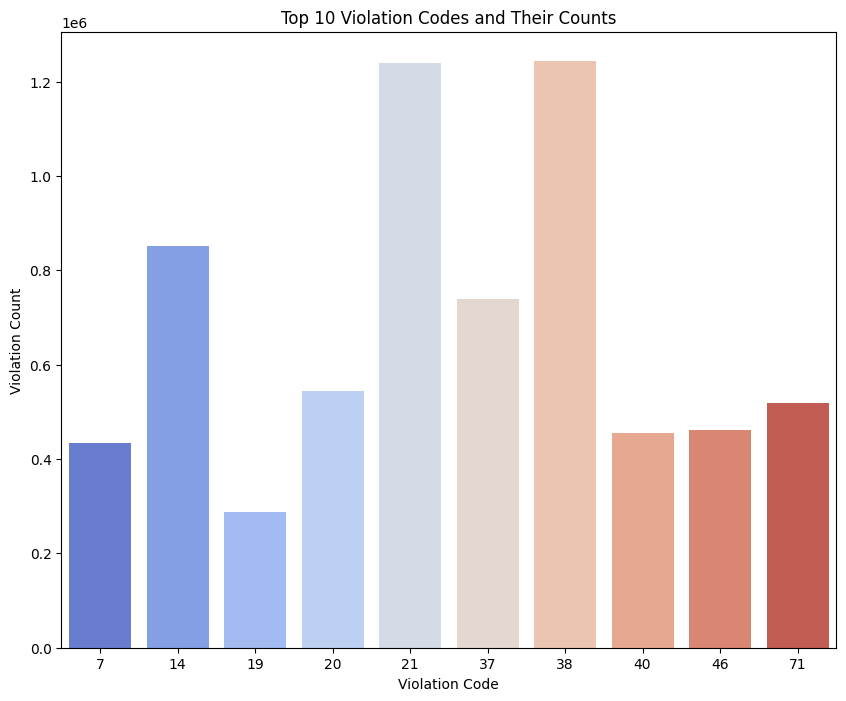

In [10]:
#Research Question: 
# Can we figure out top 10 most common violation codes and their counts ?

violation_code_counts = Date_Differences_df.groupBy("Violation Code").count().orderBy("count", ascending=False).limit(10)
violation_code_counts.show()

# Plotting a horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x="Violation Code", y="count", data=violation_code_counts.toPandas(), palette="coolwarm")
plt.title("Top 10 Violation Codes and Their Counts")
plt.xlabel("Violation Code")
plt.ylabel("Violation Count")
plt.show()

+---------+-------+
|DayOfWeek|  count|
+---------+-------+
|        1| 406357|
|        2|1453647|
|        3|1628522|
|        4|1448671|
|        5|1574559|
|        6|1556731|
|        7|1031791|
+---------+-------+



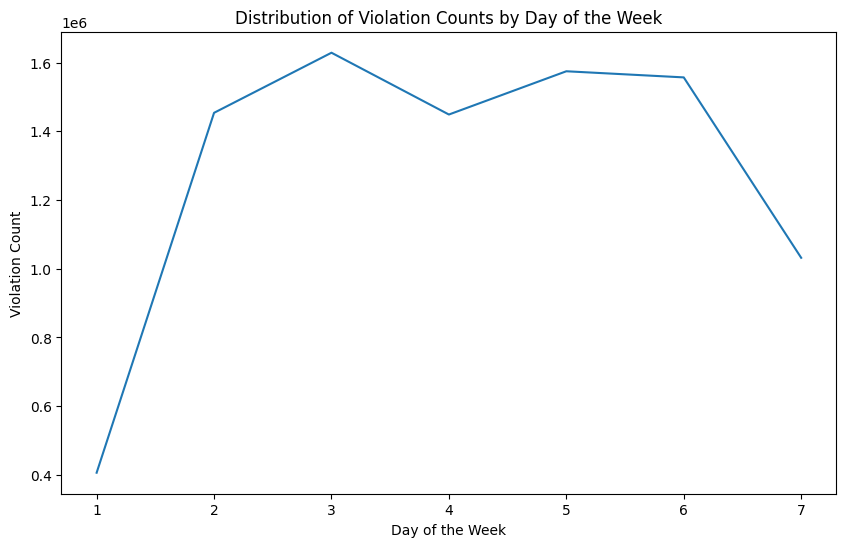

In [11]:
#Research Question:  
#How does the distribution of violation counts vary by the day of the week?
 
# Extract day of the week from the Issue Date
df = Date_Differences_df.withColumn("DayOfWeek", dayofweek("Issue Date"))

# Group by day of the week
day_of_week_counts = df.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
day_of_week_counts.show()

# Plotting a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x="DayOfWeek", y="count", data=day_of_week_counts.toPandas())
plt.title("Distribution of Violation Counts by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Violation Count")
plt.show()

+------------+-------+
|Vehicle Make|  count|
+------------+-------+
|        FORD|1248622|
|       TOYOT| 878786|
|       HONDA| 810460|
|       CHEVR| 743556|
|       NISSA| 655276|
|       DODGE| 316499|
|         GMC| 313671|
|       ME/BE| 299845|
|       FRUEH| 289634|
|       INTER| 277444|
|         BMW| 270968|
|        JEEP| 213572|
|       HYUND| 190631|
|       LEXUS| 181642|
|       ACURA| 161959|
+------------+-------+



C:\Users\pavan\AppData\Local\Temp\ipykernel_33420\2784788609.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Vehicle Make", data=top_vehicle_make_counts.toPandas(), palette="Set2")


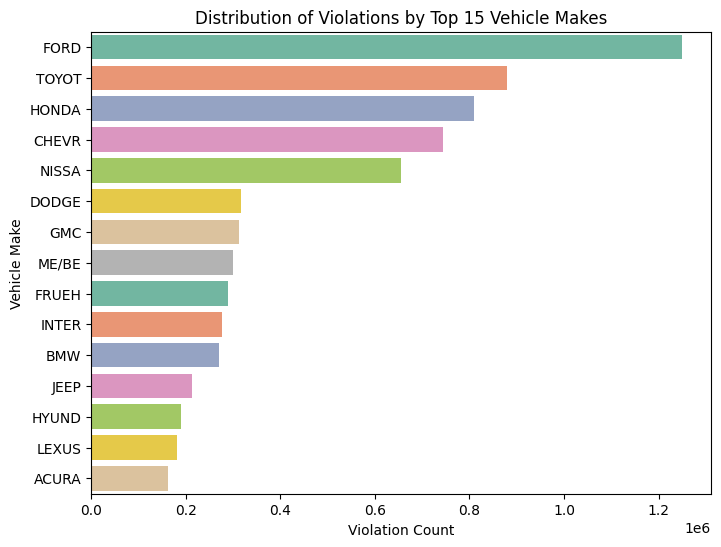

In [12]:
#Research Question:   
# What are the top 15 vehicle make contributing violations ?

top_vehicle_make_counts = df.groupBy("Vehicle Make").count().orderBy("count", ascending=False).limit(15)
top_vehicle_make_counts.show()

# Plotting a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="count", y="Vehicle Make", data=top_vehicle_make_counts.toPandas(), palette="Set2")
plt.title("Distribution of Violations by Top 15 Vehicle Makes")
plt.xlabel("Violation Count")
plt.ylabel("Vehicle Make")
plt.show()